# Team Additions

With an exciting offseason and free agency period already underway, there's no better time to see how the different roster additions (and subtractions) could affect the landscape of the 2019-2020 NBA season. This tutorial is motivated by some great content coming out of NBA Twitter surrounding free agency. Kirk Goldsberry is producing his recognizable [shooting charts](https://twitter.com/kirkgoldsberry/status/1145501240639422464) and Positive Residual is visualizing the difference in [shooting styles between players](https://twitter.com/presidual/status/1145739824046804995).

The following explores the `LeagueDash` and `Image` classes of the [py_ball](https://github.com/basketballrelativity/py_ball) package by exploring various endpoints of the [stats.nba.com](https://stats.nba.com) API. The goal of this tutorial is to produce an image or sheet to visualize how a player may be able to impact his new team.

In [1]:
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import matplotlib.image as mpimg
from matplotlib.cm import get_cmap

import itertools
from scipy.stats import percentileofscore
from scipy.stats import gaussian_kde

# Used for writing roster-addition sheets
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch, cm
from reportlab.lib.pagesizes import letter
from reportlab.lib.utils import ImageReader

from PIL import Image
import time

from py_ball import league_dash, image

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'Referer': 'stats.nba.com',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `LeagueDash` class requires a lot of parameters, but this allows for greater flexibility:
- LeagueID: The unique identifier for the league, '00' for NBA, '10' for WNBA
- PerMode: Type of 'per' data to return, such as 'Per100Possessions' or 'Per36'
- PlusMinus: 'Y' or 'N' indicating whether plus/minus data should be returned
- Rank: 'Y' or 'N' indicating whether rank data should be returned
- PaceAdjust: 'Y' or 'N' indicating whether data returned should be pace adjusted
- MeasureType: String indicating the type of statistics to be returned, such as 'Base', 'Advanced', or 'Defense'
- Period: String indicating the quarter for data to be returned. '0' returns data across all quarters
- VsConference: Conference of the opposing team. '' returns data across both conferences
- Location: String indicating the game location of data to be returned. '' returns data across both home and road games
- Outcome: String indicating the game result of data to be returned. '' returns data across both wins ('W') and losses ('L')
- DateFrom: String of a date in a MM/DD/YYYY format indicating the start date for which data is to be returned (inclusive)
- DateTo: String of a date in a MM/DD/YYYY format indicating the end date for which data is to be returned (inclusive)
- TeamID: Unique identifier of a team for which data is to be returned
- OpponentTeamID: Unique identifier of an opposing team for which data is to be returned
- Season: String of a two-year season in a YYYY-ZZ format, where the ZZ are the last two digits of the following year. For example, '2017-18' is a valid value of **Season** and represents the 2017-18 NBA season.
- VsDivision: Division of the opposing team. '' returns data across all divisions
- GameSegment: Section of the game for which data is to be returned. '' returns data throughout the entire game
- Month: Integer indicating the month for which data is to be returned. '' returns data across all months
- SeasonType: String indicating the type of season for data to be returned. One of 'Regular Season', 'Pre Season', 'All Star', or 'Playoffs'
- SeasonSegment: Section of the season for which data is to be returned. '' returns data both before and after the All Star break
- LastNGames: Integer indicating the number of recent games for which data is to be returned. '0' returns data across all games
- GameScope: String indicating the recency of the data to be returned. '' returns data across all games
- PlayerExperience: String indicating the level of player experience for which data is to be returned. '' returns data across all experience levels
- PlayerPosition: String indicating the player position for which data is to be returned. '' returns data across all positions
- StarterBench: String indicating whether the data returned is for starters or bench players. '' returns data for both starters and bench players


While the above may be an overwhelming set of options, the possibilities for data analysis are seemingly endless. For example, you can investigate player performance over the past 14 days for centers off the bench. Mixing and matching the options available should meet a lot of analysts' needs.

Below, let's pull 2018-19 full season rank data by player.

In [2]:
league_id = '00'
per_mode = 'Per100Possessions'
plus_minus = 'N'
rank = 'Y'
pace_adjust = 'N'
measure_type = 'Base'
period = '0'
vs_conference = ''
location = ''
outcome = ''
date_from = ''
date_to = ''
team_id = ''
opp_team_id = '0'
season = '2018-19'
vs_division = ''
game_segment = ''
month = '0'
season_type = 'Regular Season'
season_segment = ''
last_n_games = '0'
game_scope = ''
player_experience = ''
player_position = ''
starters_bench = ''

league_d = league_dash.LeagueDash(headers=HEADERS,
                                  endpoint='leaguedashplayerstats',
                                  league_id=league_id,
                                  per_mode=per_mode,
                                  plus_minus=plus_minus,
                                  rank=rank,
                                  pace_adjust=pace_adjust,
                                  measure_type=measure_type,
                                  period=period,
                                  vs_conference=vs_conference,
                                  location=location,
                                  outcome=outcome,
                                  date_from=date_from,
                                  date_to=date_to,
                                  team_id=team_id,
                                  opp_team_id=opp_team_id,
                                  season=season,
                                  vs_division=vs_division,
                                  game_segment=game_segment,
                                  month=month,
                                  season_type=season_type,
                                  season_segment=season_segment,
                                  last_n_games=last_n_games,
                                  game_scope=game_scope,
                                  player_experience=player_experience,
                                  player_position=player_position,
                                  starters_bench=starters_bench)

league_df = pd.DataFrame(league_d.data['LeagueDashPlayerStats'])
league_df.head(10)

,AGE,AST,AST_RANK,BLK,BLKA,BLKA_RANK,BLK_RANK,CFID,CFPARAMS,DD2,...,TD3,TD3_RANK,TEAM_ABBREVIATION,TEAM_ID,TOV,TOV_RANK,W,W_PCT,W_PCT_RANK,W_RANK
0,23.0,5.3,154,1.0,1.0,211,165,5,"203932,1610612753",19,...,0,38,ORL,1610612753,3.0,148,40,0.513,245,113
1,22.0,6.2,118,0.9,0.9,260,188,5,"1628988,1610612754",0,...,0,38,IND,1610612754,2.9,160,31,0.620,134,187
2,25.0,1.3,492,0.8,0.5,404,230,5,"1627846,1610612760",0,...,0,38,OKC,1610612760,1.7,380,38,0.623,132,132
3,33.0,6.8,94,2.1,0.7,335,58,5,"201143,1610612738",10,...,1,16,BOS,1610612738,2.5,236,41,0.603,152,103
4,28.0,2.2,419,0.7,0.6,372,262,5,"202329,1610612757",12,...,0,38,POR,1610612757,1.5,435,52,0.642,112,18
5,26.0,5.1,164,0.0,0.0,493,473,5,"1626210,1610612751",0,...,0,38,BKN,1610612751,1.7,384,1,0.200,496,499
6,27.0,4.5,193,0.7,1.3,119,245,5,"202692,1610612758",1,...,0,38,SAC,1610612758,2.3,267,19,0.297,448,307
7,25.0,1.6,478,0.5,0.5,425,345,5,"203518,1610612760",0,...,0,38,OKC,1610612760,1.1,486,21,0.677,74,284
8,25.0,6.8,98,0.8,1.6,68,231,5,"1627936,1610612747",3,...,0,38,LAL,1610612747,3.7,73,8,0.320,435,424
9,26.0,2.5,374,2.0,1.3,116,61,5,"203458,1610612737",9,...,0,38,ATL,1610612737,2.8,169,28,0.364,406,219


In [3]:
list(league_df)

['AGE',
 'AST',
 'AST_RANK',
 'BLK',
 'BLKA',
 'BLKA_RANK',
 'BLK_RANK',
 'CFID',
 'CFPARAMS',
 'DD2',
 'DD2_RANK',
 'DREB',
 'DREB_RANK',
 'FG3A',
 'FG3A_RANK',
 'FG3M',
 'FG3M_RANK',
 'FG3_PCT',
 'FG3_PCT_RANK',
 'FGA',
 'FGA_RANK',
 'FGM',
 'FGM_RANK',
 'FG_PCT',
 'FG_PCT_RANK',
 'FTA',
 'FTA_RANK',
 'FTM',
 'FTM_RANK',
 'FT_PCT',
 'FT_PCT_RANK',
 'GP',
 'GP_RANK',
 'L',
 'L_RANK',
 'MIN',
 'MIN_RANK',
 'NBA_FANTASY_PTS',
 'NBA_FANTASY_PTS_RANK',
 'OREB',
 'OREB_RANK',
 'PF',
 'PFD',
 'PFD_RANK',
 'PF_RANK',
 'PLAYER_ID',
 'PLAYER_NAME',
 'PLUS_MINUS',
 'PLUS_MINUS_RANK',
 'PTS',
 'PTS_RANK',
 'REB',
 'REB_RANK',
 'STL',
 'STL_RANK',
 'TD3',
 'TD3_RANK',
 'TEAM_ABBREVIATION',
 'TEAM_ID',
 'TOV',
 'TOV_RANK',
 'W',
 'W_PCT',
 'W_PCT_RANK',
 'W_RANK']

The data returned contains full season performance across a litany of statistics, including league-wide rankings in certain statistics. Correspondingly, we can pull 2018-19 full season rank data by team.

In [4]:
team_d = league_dash.LeagueDash(headers=HEADERS,
                                endpoint='leaguedashteamstats',
                                league_id=league_id,
                                per_mode=per_mode,
                                plus_minus=plus_minus,
                                rank=rank,
                                pace_adjust=pace_adjust,
                                measure_type=measure_type,
                                period=period,
                                vs_conference=vs_conference,
                                location=location,
                                outcome=outcome,
                                date_from=date_from,
                                date_to=date_to,
                                team_id=team_id,
                                opp_team_id=opp_team_id,
                                season=season,
                                vs_division=vs_division,
                                game_segment=game_segment,
                                month=month,
                                season_type=season_type,
                                season_segment=season_segment,
                                last_n_games=last_n_games,
                                game_scope=game_scope,
                                player_experience=player_experience,
                                player_position=player_position,
                                starters_bench=starters_bench)

team_df = pd.DataFrame(team_d.data['LeagueDashTeamStats'])
team_df.tail(20)

,AST,AST_RANK,BLK,BLKA,BLKA_RANK,BLK_RANK,CFID,CFPARAMS,DREB,DREB_RANK,...,STL,STL_RANK,TEAM_ID,TEAM_NAME,TOV,TOV_RANK,W,W_PCT,W_PCT_RANK,W_RANK
10,21.4,28,5.0,4.5,10,16,10,Houston Rockets,32.1,28,...,8.6,4,1610612745,Houston Rockets,13.5,9,53,0.646,5,5
11,26.3,3,5.0,5.2,24,15,10,Indiana Pacers,34.2,17,...,8.8,2,1610612754,Indiana Pacers,13.9,15,48,0.585,11,11
12,23.2,21,4.5,5.9,29,22,10,LA Clippers,34.6,14,...,6.6,26,1610612746,LA Clippers,14.1,19,48,0.585,11,11
13,24.6,13,5.2,4.9,16,10,10,Los Angeles Lakers,35.0,12,...,7.2,17,1610612747,Los Angeles Lakers,15.0,28,37,0.451,20,20
14,24.4,16,5.6,5.0,17,4,10,Memphis Grizzlies,33.6,23,...,8.5,6,1610612763,Memphis Grizzlies,14.3,23,33,0.402,22,22
15,24.5,14,5.5,4.8,12,5,10,Miami Heat,35.4,8,...,7.7,14,1610612748,Miami Heat,14.9,26,39,0.476,17,17
16,25.0,10,5.7,4.6,11,3,10,Milwaukee Bucks,38.9,1,...,7.2,18,1610612749,Milwaukee Bucks,13.3,7,60,0.732,1,1
17,24.2,18,4.9,5.5,25,19,10,Minnesota Timberwolves,33.0,25,...,8.2,7,1610612750,Minnesota Timberwolves,12.9,5,36,0.439,21,21
18,25.9,6,5.2,5.2,23,9,10,New Orleans Pelicans,34.7,13,...,7.1,21,1610612740,New Orleans Pelicans,14.2,22,33,0.402,22,22
19,20.0,30,5.1,5.6,26,11,10,New York Knicks,34.1,18,...,6.8,23,1610612752,New York Knicks,14.0,17,17,0.207,30,30


With the data gathered, we can now turn our attention to some aesthetics. Using the `Logo` and `Headshot` classes, the report will look more professional and polished. Let's test out pulling logos and headshots. The team IDs can be found in the `team_df` DataFrame, and the player IDs can be found in the `league_df` DataFrame. Alterantively, the URL of player pages contain the player ID on both [stats.nba.com](https://stats.nba.com) and [stats.wnba.com](https://stats.wnba.com).

In [5]:
img_team_id = 1610612755
team_logo = image.Logo(league='NBA',
                       team_id=str(img_team_id))

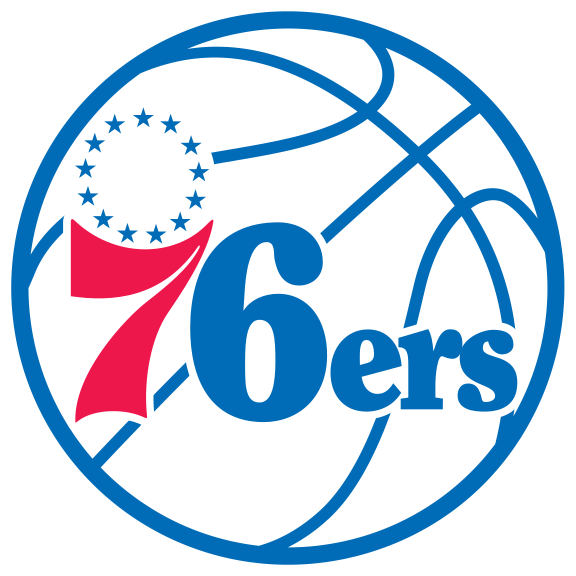

In [6]:
team_logo.image

In [7]:
headshot = image.Headshot(league='NBA',
                          player_id='203954',
                          team_id=str(img_team_id),
                          season='2018')

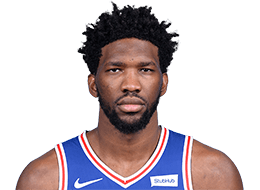

In [8]:
headshot.image

We now have all pieces needed to put together a roster addition sheet! Including the right statistics on the sheet will make the output more valuable. To start, let's include:

- AST_TO: Assist-to-turnover ratio
- BLK: Blocks per 100 possessions
- DEF_RATING: Defensive rating
- DREB_PCT: Ratio of defensive rebounds to available defensive rebounds
- OREB_PCT: Ratio of offensive rebounds to available offensive rebounds
- OFF_RATING: Offensive rating
- USG_PCT: Usage percentage
- FG3A: Three-point field-goal attempts
- FG3_PCT: Three-point field-goal percentage
- FGA: Field-goal attempts
- FG_PCT: Field-goal percentage
- FTA: Free-throw attempts
- FT_PCT: Free-throw percentage
- PFD: Personal fouls drawn

To get all of this, we need both 'Base' and 'Advanced' `measure_type` data. We already have the 'Base' data, so let's pull the 'Advanced' data.

In [9]:
measure_type = 'Advanced'
league_d = league_dash.LeagueDash(headers=HEADERS,
                                  endpoint='leaguedashplayerstats',
                                  league_id=league_id,
                                  per_mode=per_mode,
                                  plus_minus=plus_minus,
                                  rank=rank,
                                  pace_adjust=pace_adjust,
                                  measure_type=measure_type,
                                  period=period,
                                  vs_conference=vs_conference,
                                  location=location,
                                  outcome=outcome,
                                  date_from=date_from,
                                  date_to=date_to,
                                  team_id=team_id,
                                  opp_team_id=opp_team_id,
                                  season=season,
                                  vs_division=vs_division,
                                  game_segment=game_segment,
                                  month=month,
                                  season_type=season_type,
                                  season_segment=season_segment,
                                  last_n_games=last_n_games,
                                  game_scope=game_scope,
                                  player_experience=player_experience,
                                  player_position=player_position,
                                  starters_bench=starters_bench)

league_adv_df = pd.DataFrame(league_d.data['LeagueDashPlayerStats'])

In [10]:
team_d = league_dash.LeagueDash(headers=HEADERS,
                                endpoint='leaguedashteamstats',
                                league_id=league_id,
                                per_mode=per_mode,
                                plus_minus=plus_minus,
                                rank=rank,
                                pace_adjust=pace_adjust,
                                measure_type=measure_type,
                                period=period,
                                vs_conference=vs_conference,
                                location=location,
                                outcome=outcome,
                                date_from=date_from,
                                date_to=date_to,
                                team_id=team_id,
                                opp_team_id=opp_team_id,
                                season=season,
                                vs_division=vs_division,
                                game_segment=game_segment,
                                month=month,
                                season_type=season_type,
                                season_segment=season_segment,
                                last_n_games=last_n_games,
                                game_scope=game_scope,
                                player_experience=player_experience,
                                player_position=player_position,
                                starters_bench=starters_bench)

team_adv_df = pd.DataFrame(team_d.data['LeagueDashTeamStats'])

In [11]:
list(league_adv_df)

['AGE',
 'AST_PCT',
 'AST_PCT_RANK',
 'AST_RATIO',
 'AST_RATIO_RANK',
 'AST_TO',
 'AST_TO_RANK',
 'CFID',
 'CFPARAMS',
 'DEF_RATING',
 'DEF_RATING_RANK',
 'DREB_PCT',
 'DREB_PCT_RANK',
 'EFG_PCT',
 'EFG_PCT_RANK',
 'FGA',
 'FGA_PG',
 'FGA_PG_RANK',
 'FGA_RANK',
 'FGM',
 'FGM_PG',
 'FGM_PG_RANK',
 'FGM_RANK',
 'FG_PCT',
 'FG_PCT_RANK',
 'GP',
 'GP_RANK',
 'L',
 'L_RANK',
 'MIN',
 'MIN_RANK',
 'NET_RATING',
 'NET_RATING_RANK',
 'OFF_RATING',
 'OFF_RATING_RANK',
 'OREB_PCT',
 'OREB_PCT_RANK',
 'PACE',
 'PACE_RANK',
 'PIE',
 'PIE_RANK',
 'PLAYER_ID',
 'PLAYER_NAME',
 'REB_PCT',
 'REB_PCT_RANK',
 'TEAM_ABBREVIATION',
 'TEAM_ID',
 'TM_TOV_PCT',
 'TM_TOV_PCT_RANK',
 'TS_PCT',
 'TS_PCT_RANK',
 'USG_PCT',
 'USG_PCT_RANK',
 'W',
 'W_PCT',
 'W_PCT_RANK',
 'W_RANK',
 'eDEF_RATING',
 'eDEF_RATING_RANK',
 'eNET_RATING',
 'eNET_RATING_RANK',
 'eOFF_RATING',
 'eOFF_RATING_RANK',
 'ePACE',
 'ePACE_RANK',
 'sp_work_DEF_RATING',
 'sp_work_DEF_RATING_RANK',
 'sp_work_NET_RATING',
 'sp_work_NET_RATING_RANK

In [12]:
player_df = league_df[['AGE', 'BLK', 'BLK_RANK', 'FG3A', 'FG3A_RANK', 'FG3_PCT', 'FG3_PCT_RANK', 'FGA',
                       'FGA_RANK', 'FG_PCT', 'FG_PCT_RANK', 'FTA', 'FTA_RANK', 'FT_PCT', 'FT_PCT_RANK',
                       'MIN', 'MIN_RANK', 'PFD', 'PFD_RANK', 'PLAYER_ID', 'PLAYER_NAME']].merge(
                league_adv_df[['AST_TO', 'AST_TO_RANK', 'DEF_RATING', 'DEF_RATING_RANK',
                               'DREB_PCT', 'DREB_PCT_RANK', 'OFF_RATING', 'OFF_RATING_RANK',
                               'OREB_PCT', 'OREB_PCT_RANK', 'USG_PCT', 'USG_PCT_RANK',
                               'TS_PCT', 'TS_PCT_RANK', 'PLAYER_ID']], left_on='PLAYER_ID', right_on='PLAYER_ID')

In [13]:
team_df = team_df[['BLK', 'BLK_RANK', 'FG3A', 'FG3A_RANK', 'FG3_PCT', 'FG3_PCT_RANK', 'FGA',
                       'FGA_RANK', 'FG_PCT', 'FG_PCT_RANK', 'FTA', 'FTA_RANK', 'FT_PCT', 'FT_PCT_RANK',
                       'MIN', 'MIN_RANK', 'PFD', 'PFD_RANK', 'TEAM_ID']].merge(
                team_adv_df[['AST_TO', 'AST_TO_RANK', 'DEF_RATING', 'DEF_RATING_RANK',
                               'DREB_PCT', 'DREB_PCT_RANK', 'OFF_RATING', 'OFF_RATING_RANK', 'OREB_PCT', 'OREB_PCT_RANK',
                               'TS_PCT', 'TS_PCT_RANK', 'TEAM_ID']], left_on='TEAM_ID', right_on='TEAM_ID')

In [14]:
team_df

,BLK,BLK_RANK,FG3A,FG3A_RANK,FG3_PCT,FG3_PCT_RANK,FGA,FGA_RANK,FG_PCT,FG_PCT_RANK,...,DEF_RATING,DEF_RATING_RANK,DREB_PCT,DREB_PCT_RANK,OFF_RATING,OFF_RATING_RANK,OREB_PCT,OREB_PCT_RANK,TS_PCT,TS_PCT_RANK
0,4.8,20,35.1,5,0.352,16,87.1,21,0.451,21,...,113.1,28,0.718,24,107.5,23,0.284,8,0.555,17
1,5.3,7,34.2,7,0.365,7,89.6,7,0.465,14,...,107.0,6,0.728,15,111.3,10,0.257,24,0.567,10
2,4.0,29,35.1,6,0.353,14,87.1,22,0.449,25,...,109.0,15,0.720,23,108.9,19,0.282,9,0.556,15
3,4.9,18,33.9,8,0.351,18,89.8,5,0.448,26,...,112.0,23,0.731,12,110.7,11,0.268,17,0.554,19
4,4.3,26,25.8,27,0.351,19,87.5,20,0.453,20,...,112.8,25,0.727,16,104.5,29,0.242,30,0.541,28
5,2.4,30,29.8,19,0.355,13,89.6,8,0.444,28,...,116.8,30,0.732,11,106.8,25,0.282,10,0.540,29
6,4.3,25,36.5,3,0.340,27,86.7,25,0.447,27,...,110.1,18,0.734,10,108.7,20,0.273,13,0.555,16
7,4.5,23,31.8,15,0.351,17,91.2,1,0.466,13,...,108.1,10,0.744,5,112.1,7,0.308,1,0.558,14
8,4.1,28,35.2,4,0.348,23,89.3,10,0.440,29,...,108.7,12,0.745,4,108.4,21,0.291,5,0.544,26
9,6.3,1,33.7,9,0.385,3,87.7,17,0.491,1,...,108.6,11,0.727,17,115.0,1,0.257,23,0.596,1


While season-level statistics give a good overview, additional data types could provide more context to the roster addition sheets. Visualizing the shotchart data of both players and teams would reveal how a player's shot distribution would complement or supplement that of his new team.

First, we'll copy over a function that draws an NBA halfcourt on a matplotlib.figure.Figure object (`draw_court`). Next, we'll estimate a shot distribution using a Gaussian kernel density estimation given shot locations over the 2018-19 regular season (`plot_shots`). For this, a `.csv` file with all shots from the season has already been pulled from the [stats.nba.com](https://stats.nba.com) API.

In [15]:
def draw_court():
    """ draw_court draws an NBA halfcourt
    
    Returns:
    
        fig (matplotlib.figure.Figure): Figure object visualizing
            an NBA court
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')

    plt.plot([-250, 250], [-40, -40], 'k-') # endline
    plt.plot([-250, 250], [430, 430], 'k-') # halfcourt line
    plt.plot([-250, -250], [-40, 430], 'k-') # sideline
    plt.plot([250, 250], [-40, 430], 'k-') # sideline
    
    plt.plot([-30, 30], [-10, -10], 'k-') # backboard
    plt.plot([-60, -60], [-40, 150], 'k-') # lane
    plt.plot([60, 60], [-40, 150], 'k-') # lane
    plt.plot([-80, -80], [-40, 150], 'k-') # lane
    plt.plot([80, 80], [-40, 150], 'k-') # lane
    plt.plot([-80, 80], [150, 150], 'k-') # foul line

    plt.plot([220, 220], [-40, 90], 'k-') # 3pt straight
    plt.plot([-220, -220], [-40, 90], 'k-') # 3pt straight

    three_point = Arc((0, 0), width=237.5*2, height=237.5*2, theta1=22, theta2=158, linewidth=1.5)
    top_key = Arc((0, 150), width=60*2, height=60*2, theta1=0, theta2=180, linewidth=1.5)
    bottom_key = Arc((0, 150), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5, linestyle='--')
    basket = Arc((0, 0), width=7.5*2, height=7.5*2, theta1=0, theta2=360, linewidth=1.5)
    restricted = Arc((0, 7.5), width=40*2, height=40*2, theta1=0, theta2=180, linewidth=1.5)
    half_court = Arc((0, 430), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5)

    axis.add_patch(three_point)
    axis.add_patch(top_key)
    axis.add_patch(bottom_key)
    axis.add_patch(basket)
    axis.add_patch(restricted)
    axis.add_patch(half_court)

    plt.ylim(-50, 450)
    axis.set_aspect(1.0)
    plt.axis('off')

    return fig, axis

In [16]:
def plot_shots(shot_df):
    """ plot_shots plots shot density given in the
    shot DataFrame provided

    @param shot_df (DataFrame): DataFrame of shots with LOC_X and
        LOC_Y columns

    Returns

        court (maplotlib.figure.Figure): Court visual with
            the fouls plotted
    """
    heatmap, heatmap_axis = draw_court()

    ymin = -40
    ymax = 430
    xmin = -250
    xmax = 250
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([-shot_df['LOC_X'], shot_df['LOC_Y']])

    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    heatmap_axis.imshow(np.rot90(Z), cmap=plt.cm.coolwarm,
                        extent=[xmin, xmax, ymin, ymax], label = 'Shot Density')
    plt.title('Shot Density', fontsize=20)

    plt.close()
    return heatmap

Let's checkout a shot density chart for James Harden to ensure everything is working properly.

In [17]:
shot_df = pd.read_csv('shotchart_2018.csv')

In [18]:
harden_df = shot_df[shot_df['PLAYER_NAME']=='James Harden']

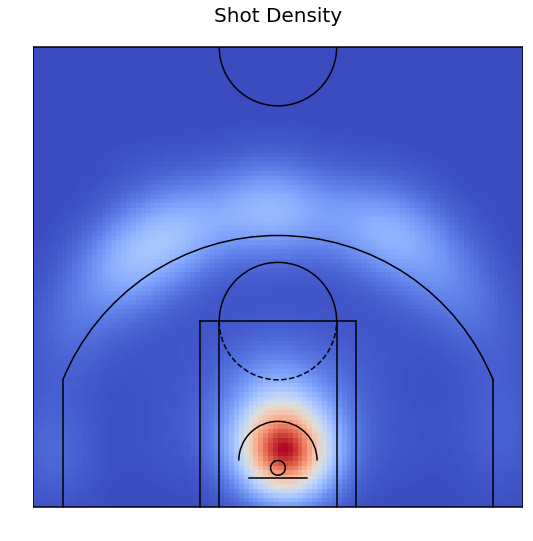

In [19]:
league_density = plot_shots(harden_df)
league_density

Armed with all of the necessary data, the below cell constructs some helper functions, along with `write_roster_sheet` that serves as the main function to produce roster addition sheets. These sheets include:
- Player name and age
- Former team logo
- New team logo
- 2018-19 team (former and new) and player percentile plots (inspired by similar charts on [baseballsavant.com](https://baseballsavant.mlb.com/savant-player/vladimir-guerrero-jr-665489?stats=career-r-hitting-mlb)
- 2018-19 shot attempt density charts

In [22]:
def draw_figure(pdf, fig, location, image_size):
    """ draw_figure draws a figure on a PDF

    @param pdf (canvas.Canvas): PDF object of summary sheet
    @param fig (matplotlib.fig.Figure): Figure object to be
        drawn on the PDF
    @param location (list): [x, y] location at which to draw
        the fig object on the PDF
    @param image_size (float): width of the image to be drawn

    Returns:

        pdf (canvas.Canvas): PDF object on which the fig
            object is drawn
    """

    img_in_memory = BytesIO()
    fig.savefig(img_in_memory, format='png', bbox_inches='tight', dpi=100)
    image = ImageReader(img_in_memory)

    # Ensure the aspect ratio is maintained
    width, height = image.getSize()
    aspect = height/float(width)

    pdf.drawImage(image, location[0], location[1], image_size, image_size*aspect)

    return pdf


def draw_image(pdf, img, location, image_size):
    """ draw_figure draws a figure on a PDF

    @param pdf (canvas.Canvas): PDF object of summary sheet
    @param img (PngImageFile): PNG Image of headshot or logo
    @param location (list): [x, y] location at which to draw
        the fig object on the PDF
    @param image_size (float): width of the image to be drawn

    Returns:

        pdf (canvas.Canvas): PDF object on which the fig
            object is drawn
    """

    # Ensure the aspect ratio is maintained
    image = ImageReader(img)

    # Ensure the aspect ratio is maintained
    width, height = image.getSize()
    aspect = height/float(width)

    pdf.drawImage(image, location[0], location[1], image_size, image_size*aspect, mask='auto')

    return pdf


def plot_percentile(perc):
    """ plot_percentile constructs a line plot that serves
    as a visualization of a percentile.

    @param perc (float): Float value from 0-100 representing
        the percentile of a statistic

    Returns:

        fig (matplotlib.fig.Figure): Figure object containing
            the percentile plot
    """

    fig = plt.figure(figsize=(9, 2))
    axis = fig.add_subplot(111, aspect='auto')

    plt.plot([0, 1], [0, 0], 'k-', linewidth=2) # endline
    plt.plot([0.5, 0.5], [-0.02, 0.02], 'k-', linewidth=2) # 50th percentile
    plt.plot([1, 1], [-0.02, 0.02], 'k-', linewidth=2) # 100th percentile
    plt.plot([0, 0], [-0.02, 0.02], 'k-', linewidth=2) # 0th percentile

    cmap = get_cmap('coolwarm')
    rgba = cmap(perc/100.0)

    plt.plot([perc/100.0], [0], color=rgba, marker='o', markersize=40)

    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 0.1)
    axis.axis('off')
    plt.close()

    return fig


def plot_info(pdf, full_df, ind_df, x_val, ext):
    """ plot_team_info visualizes team statistics by
    percentile and value

    @param pdf (canvas.Canvas): Canvas object of the roster
        addition PDF
    @param full_df (DataFrame): DataFrame containing entire league
        performance for teams or players
    @param ind_df (Series): Series containing individual
        performance for a team or player
    @param x_val (float): Initial x-coordinate for writing to the
        pdf object
    @param ext (list): List containing supplemental statistics to be
        included
    """

    fields = ['AST_TO', 'OREB_PCT', 'FG3A', 'FG3_PCT', 'FGA', 'FG_PCT',
              'FTA', 'FT_PCT', 'PFD', 'OFF_RATING', 'BLK', 'DREB_PCT', 'DEF_RATING'] + ext

    y_val = letter[1] - inch*2
    pdf.setFont('Helvetica', 12)
    for field in fields:
        perc = percentileofscore(list(full_df[field]), ind_df[field])
        fig = plot_percentile(perc)
        pdf = draw_figure(pdf, fig, [x_val - inch, y_val - 20], inch*2)
        perc_str = str(int(round(perc)))
        if perc_str[-1] == '1' and (perc_str != '11'):
            add_on = 'st'
        elif perc_str[-1] == '2' and (perc_str != '12'):
            add_on = 'nd'
        elif perc_str[-1] == '3' and (perc_str != '13'):
            add_on = 'rd'
        else:
            add_on = 'th'

        pdf.drawCentredString(x_val, y_val + 10, field + ' - ' + perc_str + add_on + ' Percentile')
        y_val -= inch*0.5

    return pdf
    

def write_roster_sheet(player_id, team_df, player_df, shot_df, from_team, to_team):
    """ write_roster_sheet creates a roster addition sheet for the player
    provided

    @param player_id (int): Unique player identifier
    @param team_df (DataFrame): DataFrame containing team data
    @param player_df (DataFrame): DataFrame containing player data
    @param player_df (DataFrame): DataFrame containing season shotchart
        data
    @param from_team (int): Unique team identifier of the
        player's former team
    @param to_team (int): Unique team identifier of the
        player's new team

    Returns:

        PDF of the format '[first_name]_[last_name]_sheet.pdf'
            written in the current working directory
    """

    league_df = player_df
    player_df = player_df[player_df['PLAYER_ID']==player_id].iloc[0]
    from_df = team_df[team_df['TEAM_ID']==from_team].iloc[0]
    to_df = team_df[team_df['TEAM_ID']==to_team].iloc[0]

    pdf_object = canvas.Canvas(player_df['PLAYER_NAME'].lower().replace(' ', '_') + '_sheet.pdf')

    # Write player metadata
    pdf_object.setFont('Helvetica-Bold', 16)
    pdf_object.drawCentredString(letter[0]/2, letter[1],
                                 player_df['PLAYER_NAME'] + ' - Age ' + str(int(player_df['AGE'])))
    ###################################

    # Draw logos and images
    headshot = image.Headshot(league='NBA',
                              player_id=str(player_df['PLAYER_ID']),
                              team_id=str(from_team),
                              season='2018')

    from_logo = image.Logo(league='NBA',
                           team_id=str(from_team))
    to_logo = image.Logo(league='NBA',
                         team_id=str(to_team))
    
    pdf = draw_image(pdf_object, headshot.image, [letter[0]/2 - inch, letter[1] - inch*1.5], inch*2)
    pdf = draw_image(pdf_object, from_logo.image, [1.2*letter[0]/6 - inch, letter[1] - inch*1.5], inch*2)
    pdf = draw_image(pdf_object, to_logo.image, [3.2*letter[0]/4 - inch, letter[1] - inch*1.5], inch*2)

    ###################################

    # Draw team and player season performance
    plot_info(pdf, team_df, from_df, 1.0*letter[0]/6, [])
    plot_info(pdf, team_df, to_df, 4.7*letter[0]/6, [])
    plot_info(pdf, league_df, player_df, 2.95*letter[0]/6, ['USG_PCT'])

    player_shots = plot_shots(shot_df[shot_df['PLAYER_ID'] == player_id])
    from_shots = plot_shots(shot_df[shot_df['TEAM_ID'] == from_team])
    to_shots = plot_shots(shot_df[shot_df['TEAM_ID'] == to_team])

    pdf = draw_figure(pdf_object, player_shots, [letter[0]/2 - 1.3*inch, letter[1] - inch*11.125], inch*2.5)
    pdf = draw_figure(pdf_object, from_shots, [0.9*letter[0]/6 - inch, letter[1] - inch*11.125], inch*2.5)
    pdf = draw_figure(pdf_object, to_shots, [3.1*letter[0]/4 - inch, letter[1] - inch*11.125], inch*2.5)

    pdf_object.showPage()
    pdf_object.save()

Finally! We can produce roster addition sheets. The call below is for Al Horford (`player_id = 201143`), who went from the Celtics (`team_id = 1610612738`) to the 76ers (`team_id = 1610612755`). I also took a screenshot of the PDF result and view it below so we can gather insights from the sheet.

In [23]:
write_roster_sheet(203504, team_df, player_df, shot_df, 1610612763, 1610612755)
# write_roster_sheet(202689, team_df, player_df, shot_df, 1610612766, 1610612738) 203953, 1610612764, 1610612737

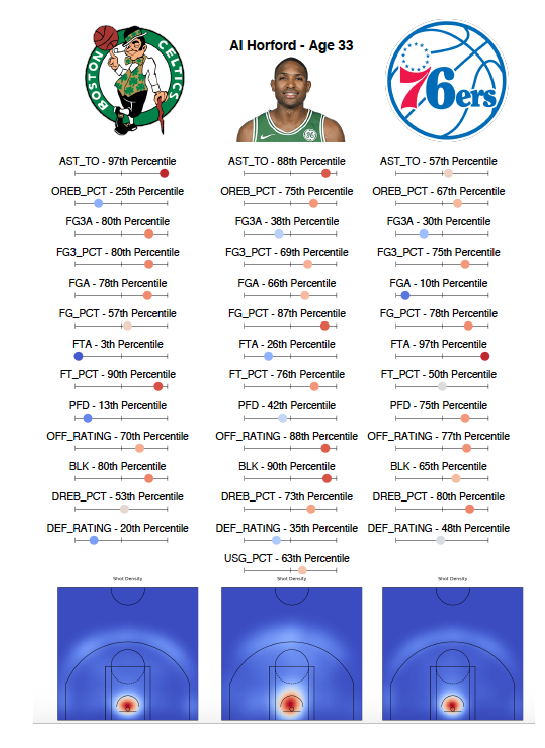

In [22]:
img = mpimg.imread('horford_img.png')
fig = plt.figure(figsize=(10.5, 10.5))
axis = fig.add_subplot(111)
img_plot = plt.imshow(img, interpolation=None)
axis.axis('off')
plt.tight_layout()
plt.show()

The percentile plots allow one to quickly see how Horford moving teams would hurt/benefit the Celtics and 76ers. A few interesting tidbits that I can spot are:

- Horford's high assist-to-turnover ratio should be a great benefit to the 76ers. Joel Embiid struggles with turnovers, so the team could use a big that can both distribute and protect the ball.
- The Celtics need to replace Horford's rebounding. The team was not elite at rebounding on either side of floor, but Horford was above average.
- Horford will help the 76ers on both ends of the floor, with above average offensive and defensive rating. The 76ers should see their rim protection get even better with Horford's 90th percentile blocks per 100 possessions.

## Exploration

- What other information would be meaningful to add to the roster addition sheet? Add another statistic or visualization.
- Can you add any other aesthetics to make the roster sheet look more appealing or professional?
- Explore other players that have changed rosters this season and try to gather insights from the roster addition sheet!